In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
mean_dict={'b': 176.9625,
            'h': 242.3,
            'd': 207.9835,
            "d'": 25.825,
            'L': 2441.0625,
            'l': 2215.75,
            'a': 794.25,
            'fck': 30.697625,
            'As': 110.73037500000001,
            'fy': 357.99725,
            "As'": 230.72625,
            "fy'": 494.216,
            'C': 0.3625,
            'PBO': 0.1875,
            'G': 0.15,
            'CF': 0.075,
            'B': 0.0375,
            'ff': 3120.6375,
            'Af': 14.595875000000001,
            'layer': 2.125,
            'Swr': 9.932500000000001,
            'Swf': 13.569999999999999,
            'Anchorage': 0.325}

std_dict={'b': 96.34890291928602,
            'h': 81.40061424829668,
            'd': 72.65806763704909,
            "d'": 18.162994659471767,
            'L': 899.6255101950755,
            'l': 849.2920213330631,
            'a': 266.5298998236408,
            'fck': 8.828589814312078,
            'As': 107.1200526330592,
            'fy': 236.85287821754986,
            "As'": 194.7459760455592,
            "fy'": 93.60362070454326,
            'C': 0.4807221130757352,
            'PBO': 0.3903123748998999,
            'G': 0.3570714214271425,
            'CF': 0.26339134382131846,
            'B': 0.18998355191963331,
            'ff': 2076.1850245326764,
            'Af': 30.569788300450742,
            'layer': 2.0938899206978383,
            'Swr': 6.126331998022961,
            'Swf': 9.863523711128797,
            'Anchorage': 0.4683748498798799}

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch

import pytorch_lightning as pl
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from nam.utils.graphing import plot_mean_feature_importance, calc_mean_prediction, plot_mean_feature_importance, plot_nams
from nam.config import defaults
from nam.data import FoldedDataset
from nam.data import NAMDataset
from nam.models import NAM
from nam.models import get_num_units
from nam.trainer import LitNAM
from nam.types import Config
from nam.utils import parse_args

/opt/homebrew/anaconda3/envs/ML/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
idx = 1
name_list = ['minmax','standard', 'robust']

x_train = pd.read_csv('data/train/standard_data.csv', index_col=0)
y_train = pd.read_csv('data/train/label.csv', index_col=0)
x_test = pd.read_csv('data/test/standard_data.csv',index_col=0)
y_test = pd.read_csv('data/test/label.csv', index_col=0)

x_train = torch.Tensor(np.array(x_train))
y_train = torch.Tensor(np.array(y_train))
x_test = torch.Tensor(np.array(x_test))
y_test = torch.Tensor(np.array(y_test))

In [7]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self,x_data,y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    def __len__(self):
        return self.len

train_dataset = MyDataset(x_train,y_train)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

test_dataset  = MyDataset(x_test,y_test)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)


In [8]:
from types import SimpleNamespace
from typing import Mapping
from typing import Sequence

import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from tqdm.autonotebook import tqdm

from nam.models.saver import Checkpointer
from nam.trainer.losses import penalized_loss
from nam.trainer.metrics import accuracy
from nam.trainer.metrics import mae
from nam.utils.loggers import TensorBoardLogger
from ray import tune
from sklearn.metrics import r2_score

def train_batch(model, optimizer, batch):
    
    features = batch[0].to(device)
    targets = batch[1].to(device)
    optimizer.zero_grad()
    
    predictions, fnn_out = model(features)
    
    loss = criterion(predictions, targets, None, fnn_out, model)
    metric = metrics(predictions, targets)
    
    loss.backward()
    optimizer.step()
    
    return loss, metric


def train_epoch(model, optimizer, dataloader):
    model.train()
    
    loss = 0.0 ; metric = 0.0
    
    with tqdm(dataloader, leave=False) as pbar:
        for batch in pbar:
            batch_loss, batch_metric = train_batch(model, optimizer, batch)
            loss += batch_loss
            metric += batch_metric

            pbar.set_description(f"[Train] Batch_loss: {batch_loss:.3f} | batch_metric: {batch_metric:.3f}")
            
    return loss/len(dataloader), metric/len(dataloader)


def evaluate_step(model, batch):
    features = batch[0].to(device)
    targets = batch[1].to(device)
    
    predictions, fnn_out = model(features)
    
    val_loss = criterion(predictions, targets, None, fnn_out, model)
    val_metric = metrics(predictions, targets)
    
    return val_loss, val_metric

def evaluate_epoch(model, dataloader, x_test, y_test, device):
    model.eval()
    loss = 0.0 ; metric = 0.0
    
    with tqdm(dataloader, leave=False) as pbar:
        for batch in pbar:
            with torch.no_grad():
                batch_loss, batch_metric = evaluate_step(model, batch)
                loss += batch_loss
                metric += batch_metric
            
                pbar.set_description(f"[Test] Batch_loss: {batch_loss:.3f} | batch_metric: {batch_metric:.3f}")
    
    
    y_pred = model(x_test.to(device))[0].cpu().detach().numpy()
    r2 = r2_score(y_test, y_pred)
    
    return r2, loss/len(dataloader), metric/len(dataloader)

In [9]:
# import warnings
# warnings.filterwarnings("ignore")

# import random
# import torch.backends.cudnn as cudnn

# torch.manual_seed(0)
# torch.cuda.manual_seed(0)
# torch.cuda.manual_seed_all(0)
# np.random.seed(0)
# cudnn.benchmark = False
# cudnn.deterministic = True
# random.seed(0)

# batches = [10,20,25,50]
# hiddens = [8,32,64,128,256]
# dropouts = [0.0]


# for batch in batches:
#     for hidden in hiddens:
#         for dropout in dropouts:
#             config = defaults()
#             config.batch_size = batch
#             config.data_path = 'data/train/standard_data.csv'
#             config.num_epochs = 100
#             config.regression = True
#             config.hidden_sizes = [hidden]
#             config.dropout = dropout


#             device = "cpu"
#             num_epochs = config.num_epochs
#             model = NAM(config=config,
#                     name='TRM',
#                     num_inputs=x_train.shape[1],
#                     num_units=350)

#             model = model.to(device)

#             metrics = lambda logits, targets: mae(logits, targets)
#             criterion = lambda inputs, targets, weights, fnns_out, model: penalized_loss(
#                         config, inputs, targets, weights, fnns_out, model)

#             optimizer = torch.optim.Adam(model.parameters(),
#                                         lr=config.lr,
#                                         weight_decay=config.decay_rate)

#             checkpointer = Checkpointer(model=model, config=config)

#             train_losses = [] ; train_metrices = []
#             test_losses = [] ; test_metices = []

#             best_r2 = 0.0
#             with tqdm(range(num_epochs)) as pbar_epoch:
#                 for epoch in pbar_epoch:
#                     train_loss, train_metric = train_epoch(model, optimizer, train_loader)
                    
#                     r2, test_loss, test_metric = evaluate_epoch(model, test_loader, x_test, y_test,device)
                    
#                     if r2 >= best_r2:
#                         best_r2 = r2
#                         if best_r2 >= 0.95:
#                             checkpointer.save(batch, hidden, dropout, r2)
                        
#                     train_losses.append(float(train_loss)) ; train_metrices.append(float(train_metric))
#                     test_losses.append(float(test_loss)) ; test_metices.append(float(test_metric))


#             print(f"batch = {batch} | hidden = {hidden} | dropout = {dropout}| r2_score = {best_r2:.3f}")

In [10]:
def weight_init_xavier_uniform(submodule):
    if isinstance(submodule, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform_(submodule.weight)
        submodule.bias.data.fill_(0.01)
    elif isinstance(submodule, torch.nn.BatchNorm2d):
        submodule.weight.data.fill_(1.0)
        submodule.bias.data.zero_()

class mlp_model(nn.Module):
    def __init__(self):
        super(mlp_model, self).__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(23,1024),
            nn.ELU(),
            nn.Linear(1024,512), 
            nn.ELU(),
            nn.Linear(512,512),  
            nn.ELU(), 
            nn.Linear(512,256),
            nn.ELU(),
            nn.Linear(256,1))

    def forward(self,x):
        self.mlp.apply(weight_init_xavier_uniform)
        output = self.mlp(x)
        return output
temp_model = torch.load("pretrained_models/best_model_fixed.pt", map_location='cpu')

In [11]:
torch.from_numpy(test_y_pred)

NameError: name 'test_y_pred' is not defined

In [12]:
y_test.squeeze(1)

tensor([ 91.1600,  98.8400,  54.8000,  93.8200,  38.4600,  42.0000,  72.4000,
         88.9000,  43.0000,  49.7700,  35.5100, 118.0000,  80.0400,  40.1200,
         45.8900,  54.8000, 126.7000,  24.8000,  91.2600,  73.4000])

/opt/homebrew/anaconda3/envs/ML/lib/python3.9/site-packages/torch/nn/init.py:176: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


<class 'numpy.ndarray'> <class 'torch.Tensor'>
MAE : 3.9589
RMSE : 5.2615
R^2 : 0.9660


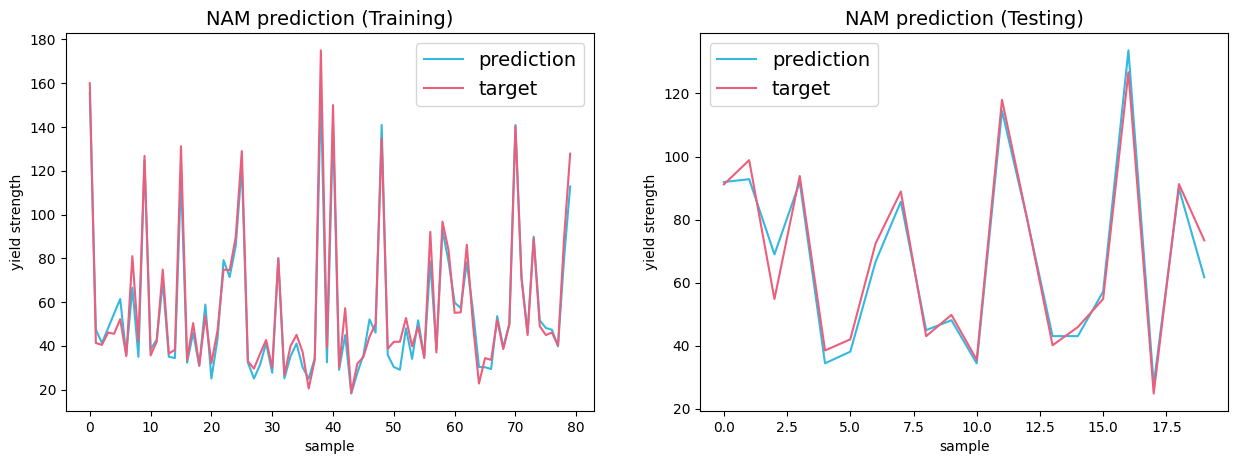

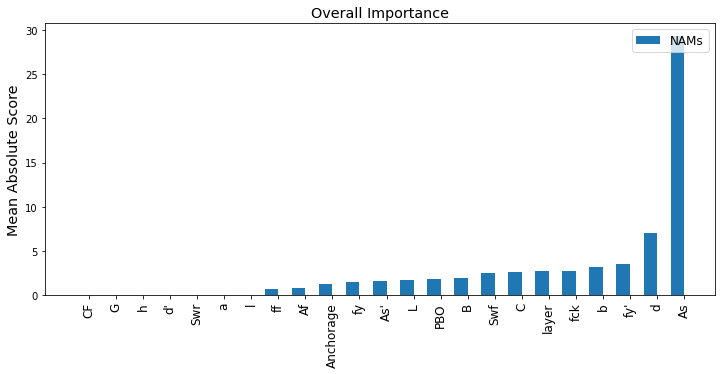

In [13]:

import matplotlib.pyplot as plt
from nam.utils import get_feature_contributions, calc_mean_prediction, plot_mean_feature_importance, plot_nams

config = defaults()
config.batch_size = 50
config.data_path = 'data/train/standard_data.csv'
config.num_epochs = 100
config.regression = True
config.hidden_sizes = [8]
config.dropout = 0.0


device = "cpu"
num_epochs = config.num_epochs
model = NAM(config=config,
        name='TRM',
        num_inputs=x_train.shape[1],
        num_units=350)


features_names = ['b', 'h', 'd', "d'", 'L', 'l', 'a', "fck", "As", "fy", "As'", "fy'",
        'C', 'PBO', 'G', 'CF', 'B', 'ff', 'Af', 'layer', 'Swr', 'Swf',
        'Anchorage']
model.load_state_dict(torch.load("pretrained_models/nam_b50_h8_d0_r966.pt", map_location=device))




# feature_to_use = features_names
device = "cpu"

train_y_pred = model(x_train.to(device))[0].cpu().detach().numpy()
test_y_pred = model(x_test.to(device))[0].cpu().detach().numpy()


print(type(train_y_pred), type(y_test))

mae = torch.sum(torch.abs(torch.from_numpy(test_y_pred) - y_test.squeeze(1)))/len(y_test)
rmse = torch.sqrt(torch.sum(torch.square(torch.from_numpy(test_y_pred) - y_test.squeeze(1)))/len(y_test))
final_r2 = r2_score(test_y_pred, y_test)


print(f"MAE : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R^2 : {final_r2:.4f}")
plt.figure(figsize=(15,5), dpi=100)

plt.subplot(1,2,1)
plt.title('NAM prediction (Training)', fontsize=14)
plt.xlabel('sample')
plt.ylabel('yield strength')
plt.plot(train_y_pred, label='prediction', color='#34b8e0')
plt.plot(y_train, label='target', color='#eb5e7c')
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.title('NAM prediction (Testing)', fontsize=14)
plt.xlabel('sample')
plt.ylabel('yield strength')
plt.plot(test_y_pred, label='prediction',color='#34b8e0')
plt.plot(y_test, label='target',color='#eb5e7c')
plt.legend(fontsize=14)

feature_contributions, unique_features, single_features = get_feature_contributions(model,x_test,device)
plot_mean_feature_importance(model, x_test, device);

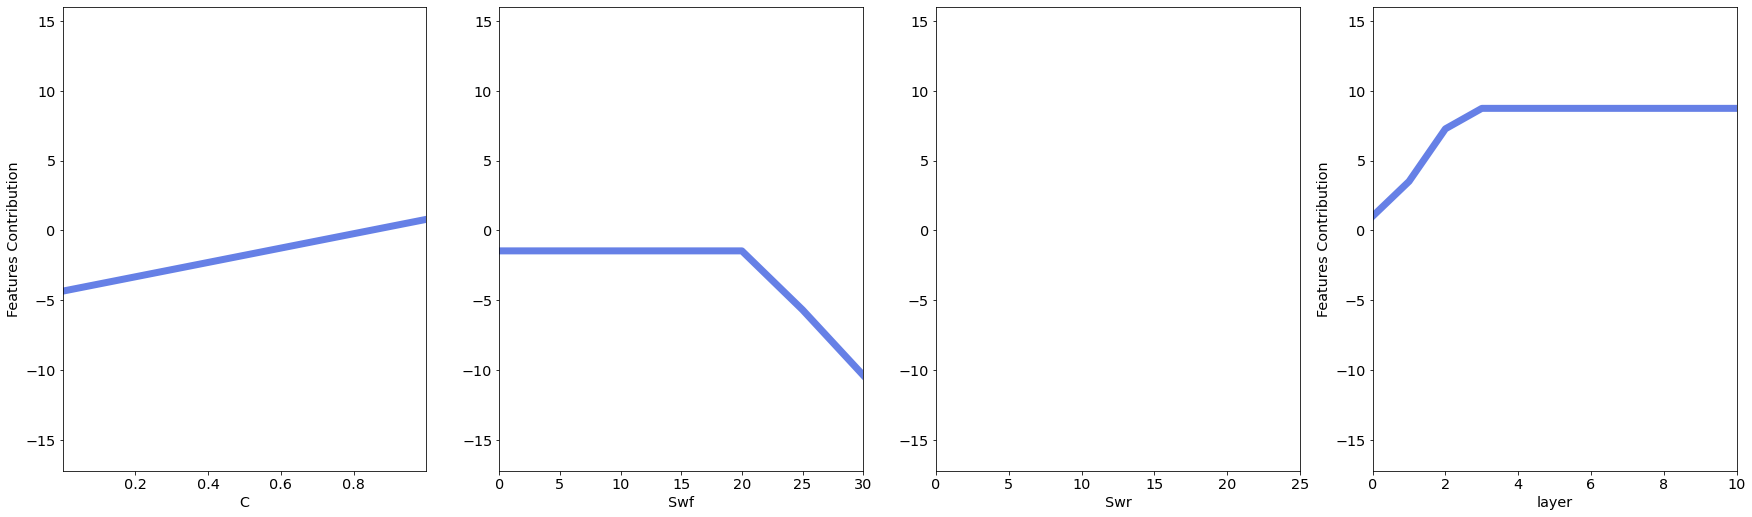

In [15]:
from nam.utils.graphing import plot_mean_feature_importance, calc_mean_prediction, plot_mean_feature_importance, plot_nams

color = [0.4, 0.5, 0.9]
linewidth = 7.0
alpha  = 1.0
feature_to_use = ["Swf","layer","C"]
# feature_to_use = features_names
plot_nams(model, x_test, 3, 24, color, linewidth, alpha,
          feature_to_use, mean_dict, std_dict,device);